In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint

In [4]:
from data_loader import *
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [5]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

size = 512

In [6]:
files = []
lbl_bbox = []

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = 1#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, level, size, size))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:06,  3.34it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:18,  1.20it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:15,  1.37it/s]

Loading DB into memory ...


 17%|█▋        | 4/24 [00:02<00:12,  1.55it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:10,  1.79it/s]

Loading DB into memory ...
Loading DB into memory ...


 33%|███▎      | 8/24 [00:03<00:06,  2.32it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:06,  2.49it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:04,  2.89it/s]

Loading DB into memory ...
Loading DB into memory ...


 50%|█████     | 12/24 [00:04<00:04,  2.91it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:02,  3.43it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:05<00:01,  3.71it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  3.65it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.54it/s]

Loading DB into memory ...


In [7]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [8]:
bs = 64
train_images = 5000
val_images = 500

train_files = list(np.random.choice(files[4:], train_images))
valid_files = list(np.random.choice(files[:4], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))

In [9]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.5, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [10]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

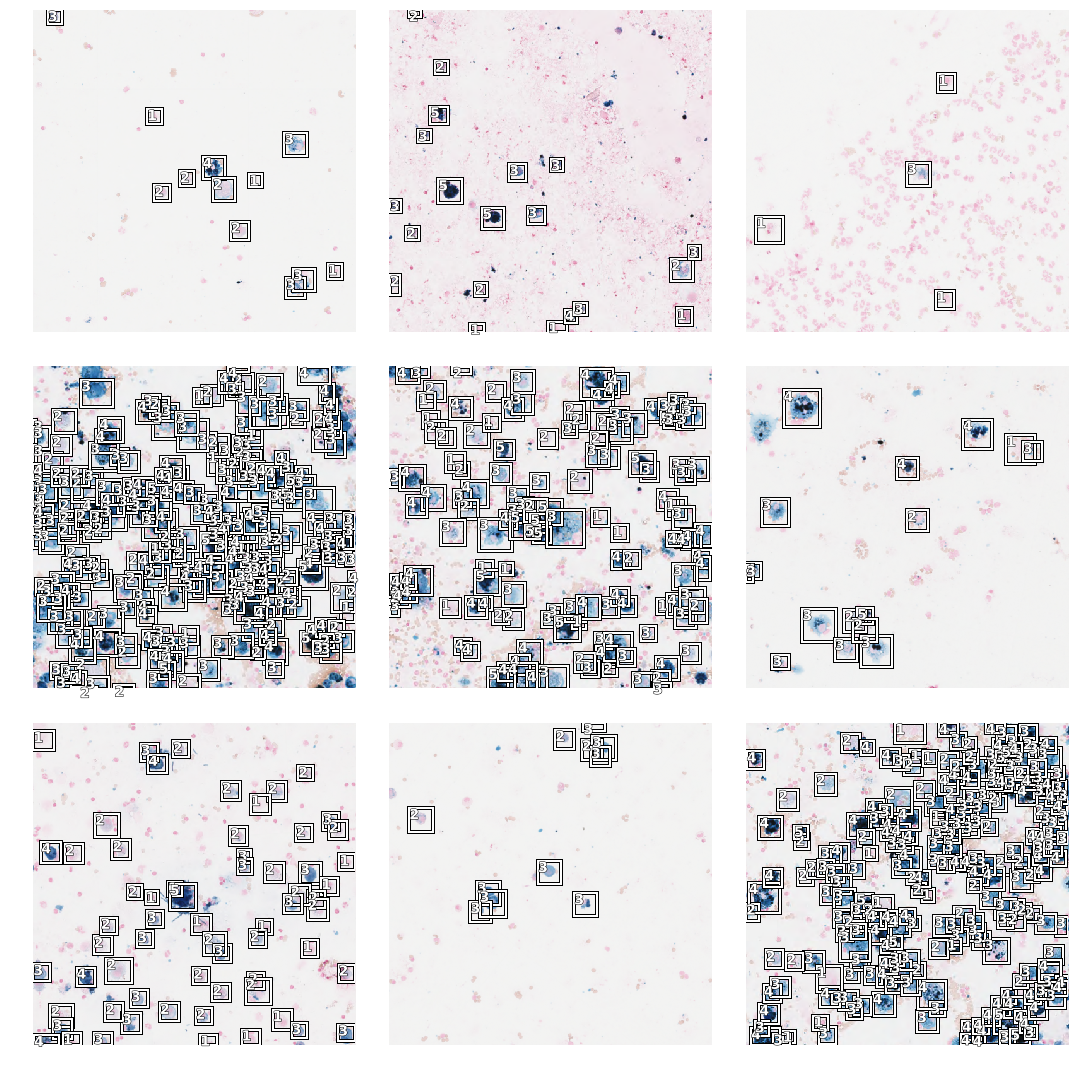

In [11]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [ ]:
scale = 2

In [11]:
anchors_32 = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.35, 0.5, 0.6])

In [12]:
anchors = anchors_32

In [183]:
anchors_16 = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.35, 0.46, 0.64])

In [184]:
anchors = anchors_16

In [137]:
anchors.shape

torch.Size([768, 4])

In [14]:
anchors

tensor([[-0.9688, -0.9688,  0.0875,  0.0875],
        [-0.9688, -0.9688,  0.1250,  0.1250],
        [-0.9688, -0.9688,  0.1500,  0.1500],
        ...,
        [ 0.9688,  0.9688,  0.0875,  0.0875],
        [ 0.9688,  0.9688,  0.1250,  0.1250],
        [ 0.9688,  0.9688,  0.1500,  0.1500]])

In [164]:
anchors = torch.cat((anchors_32, anchors_16), 0)

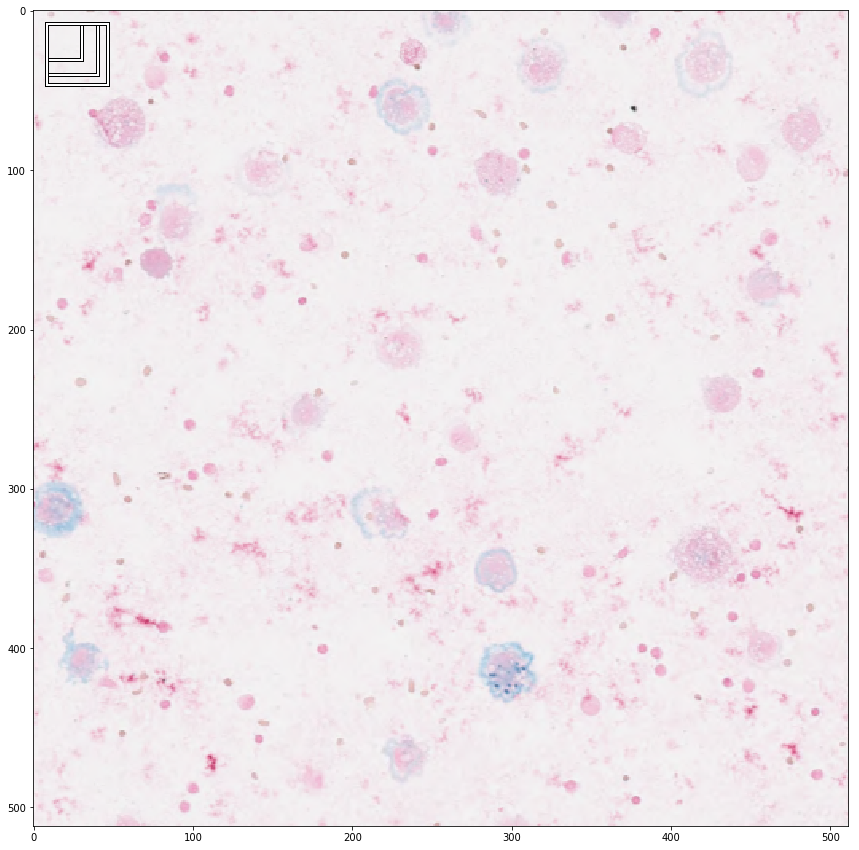

In [45]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:3]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [13]:
crit = RetinaNetFocalLoss(anchors)

In [14]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [15]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [16]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


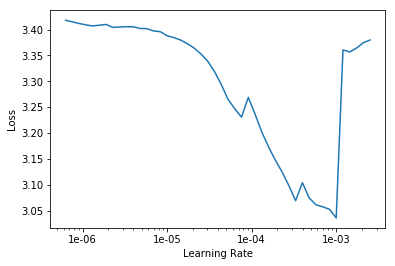

In [24]:
learn.lr_find()
learn.recorder.plot()

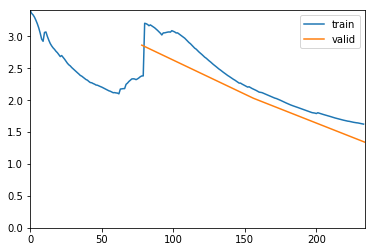

In [17]:
learn.fit_one_cycle(3, 1e-3)

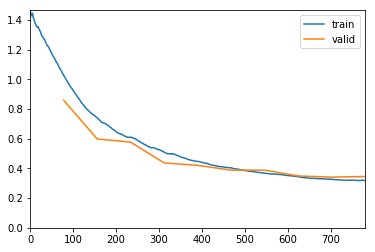

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)
#learn.save("pferd_512_1")

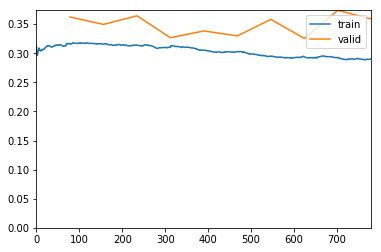

In [20]:
learn.fit_one_cycle(10, 1e-4)

In [49]:
#learn.save("pferd_1_512")
learn.export("pferd_1_512")

In [200]:
classes = data.train_ds.classes

In [201]:
classes

['background', 1, 2, 3, 4, 5]

0.005511760711669922
0.003960371017456055
0.0039038658142089844
0.003927469253540039
0.004002809524536133
0.003977775573730469
0.003984212875366211
0.00431370735168457


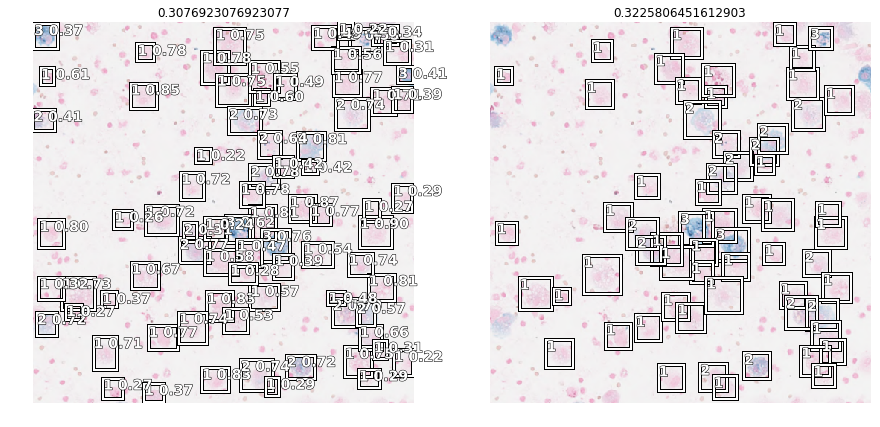

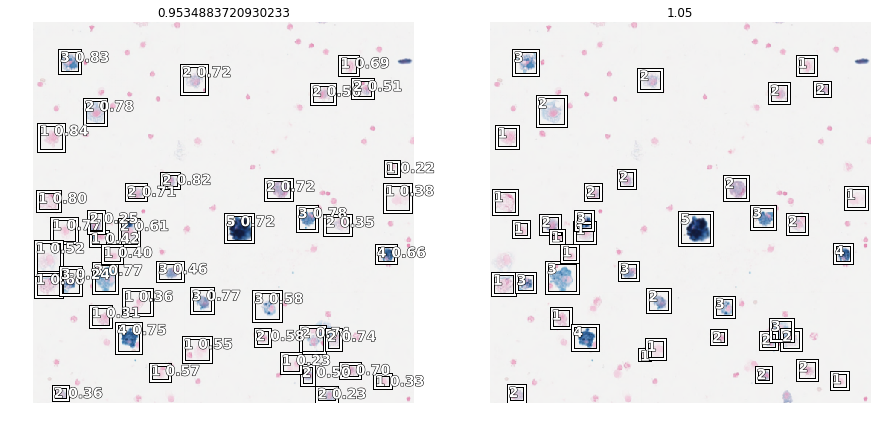

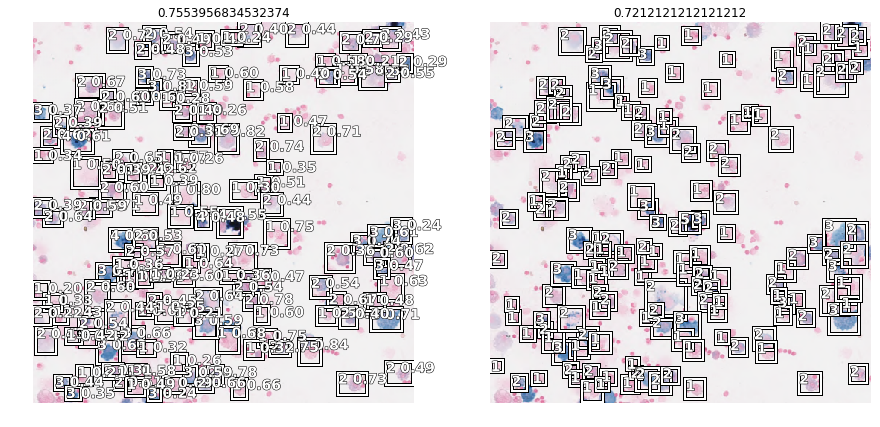

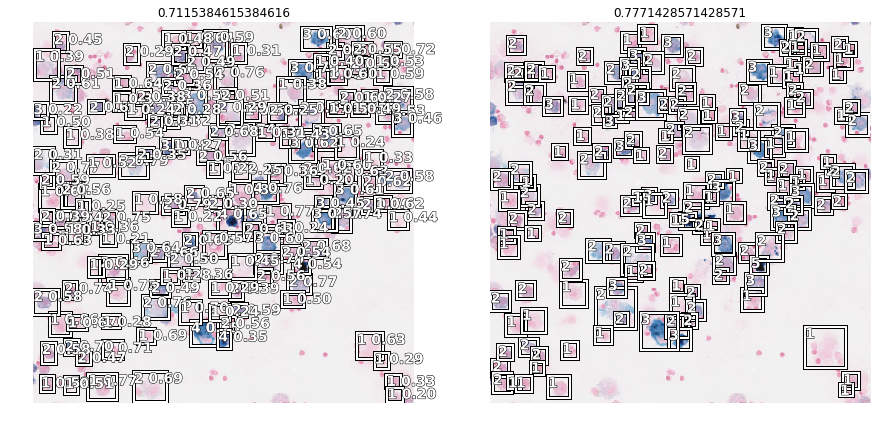

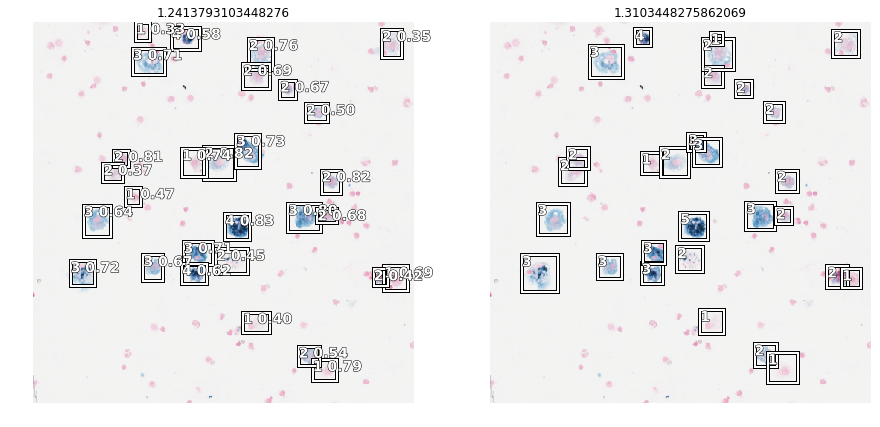

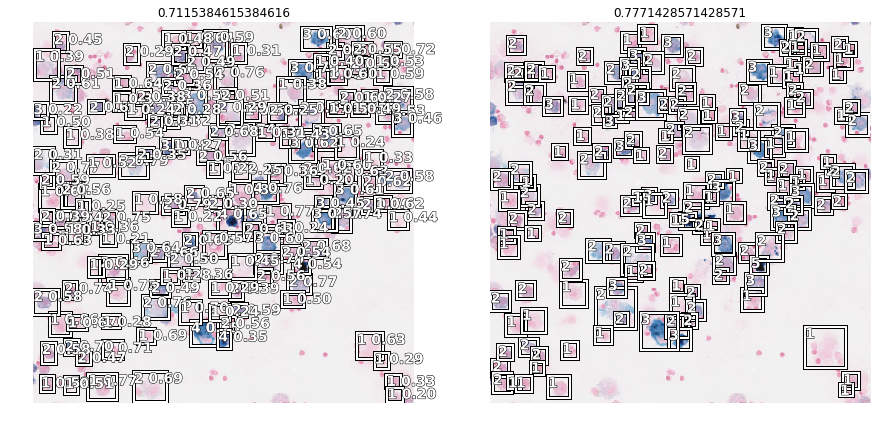

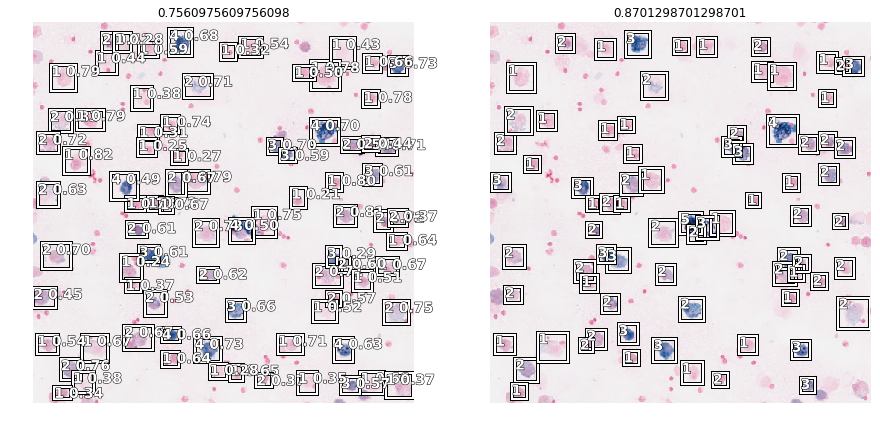

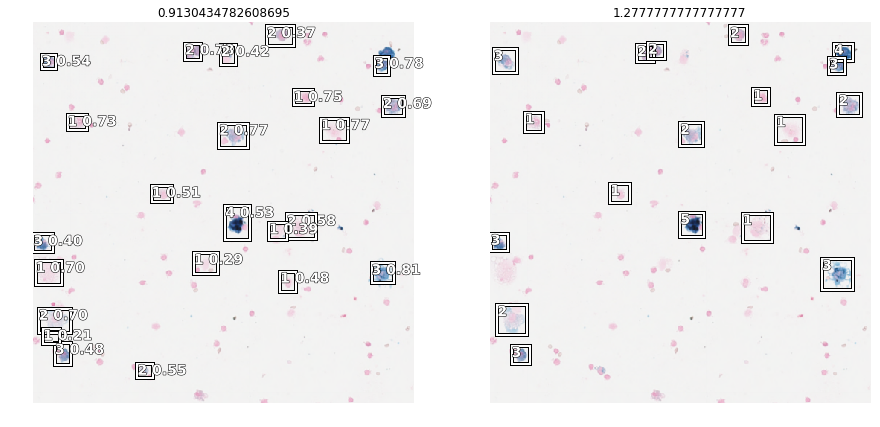

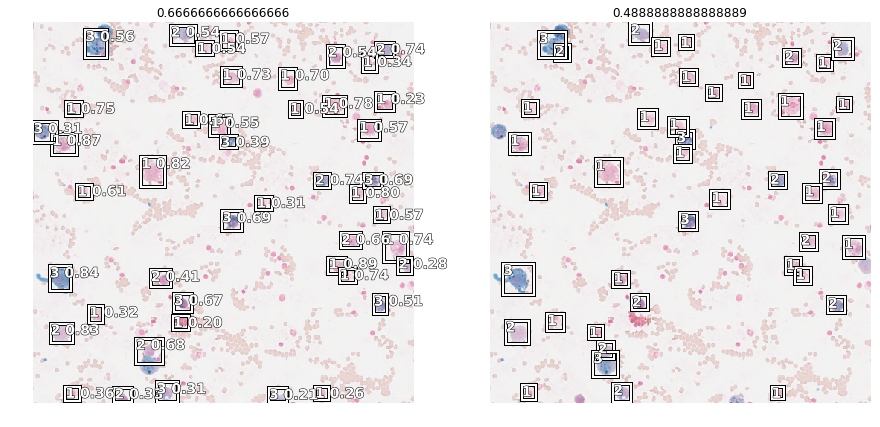

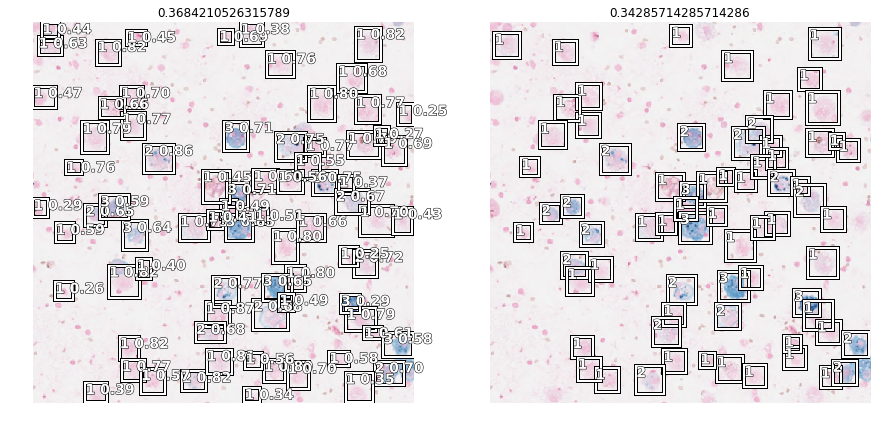

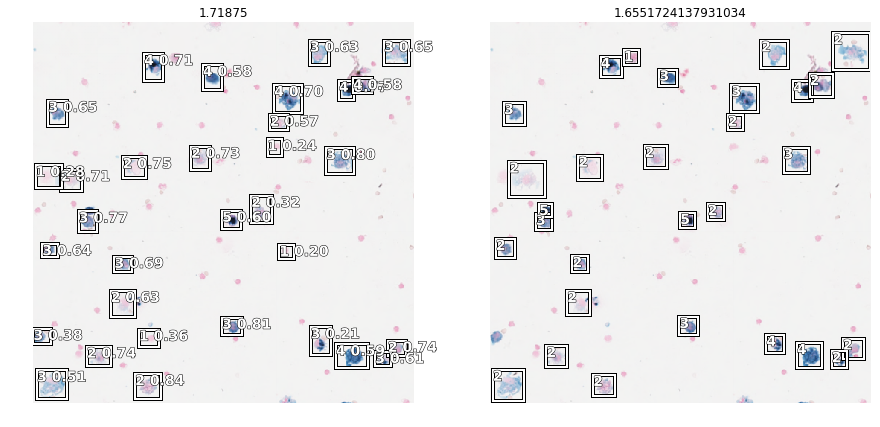

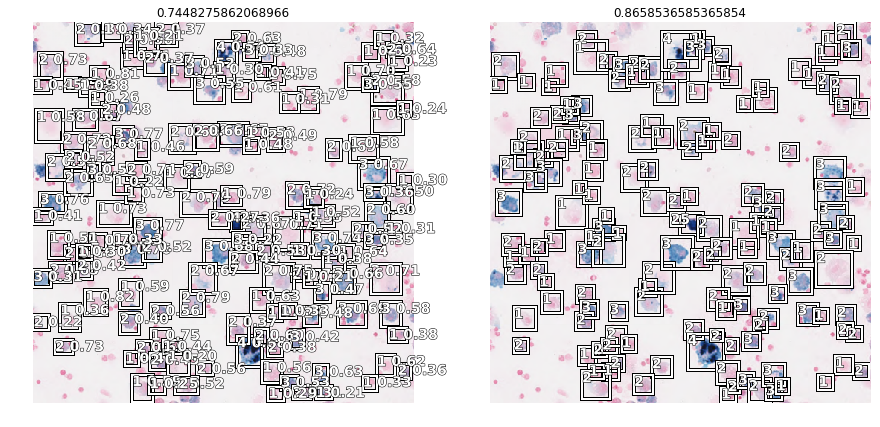

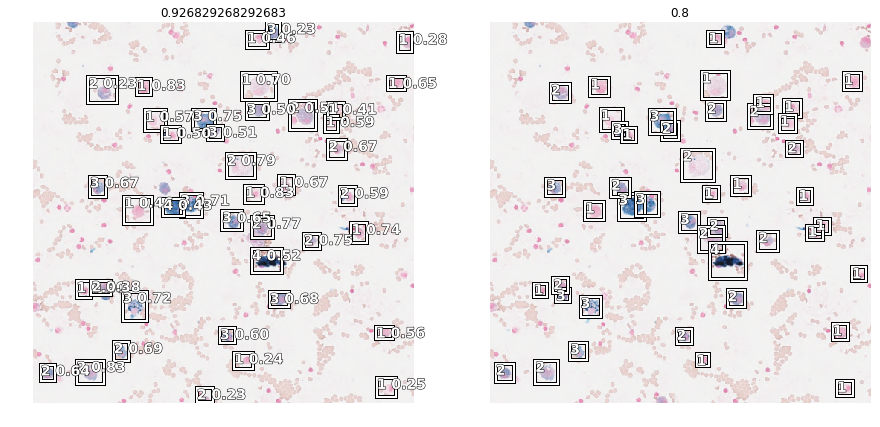

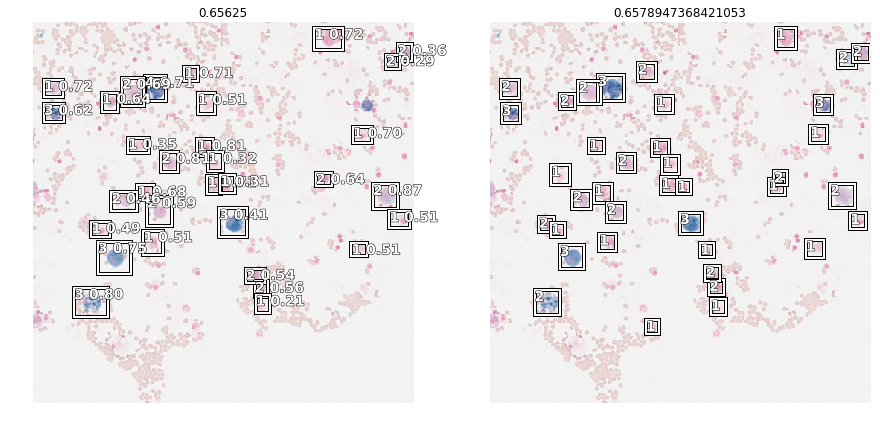

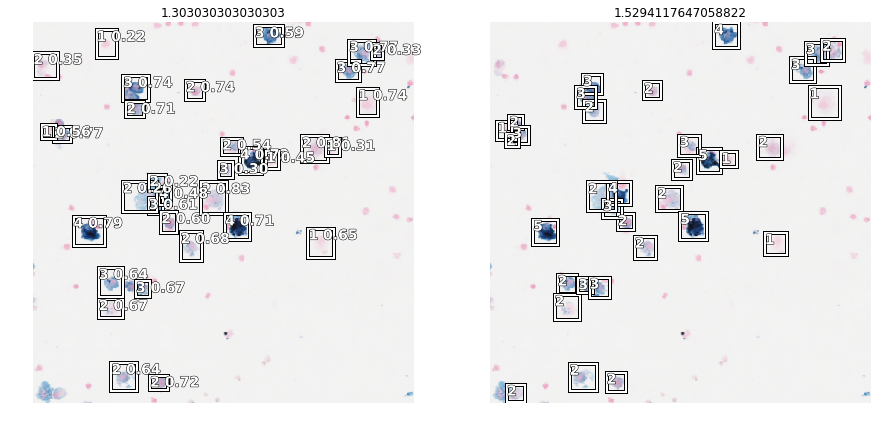

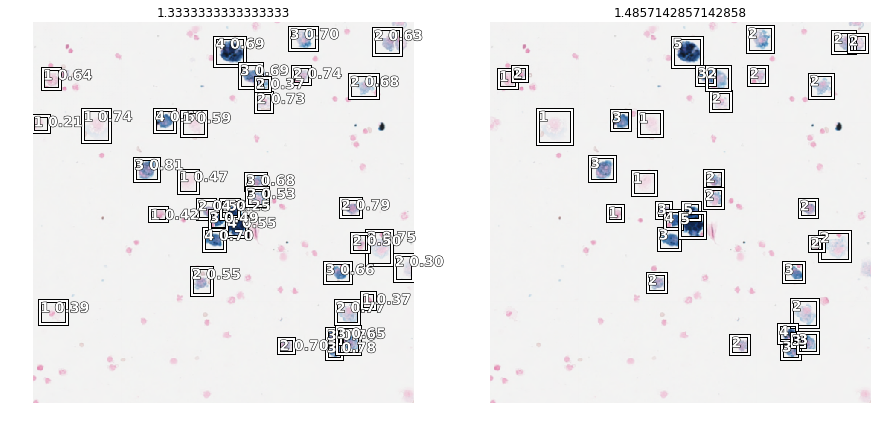

In [48]:
with torch.no_grad():
    for img_batch, target_batch in data.valid_dl:
        start = time.time()
        class_pred_batch, bbox_pred_batch, size = model(img_batch)
        print(time.time() - start)
        
        bbox_gt_batch, class_gt_batch = target_batch
        for img, bbox_gt, class_gt, clas_pred, bbox_pred in \
                list(zip(img_batch, bbox_gt_batch, class_gt_batch, class_pred_batch, bbox_pred_batch))[:2]:
            #img = Image(data.denorm(img)[0])
            bbox_gt = bbox_gt[np.nonzero(class_gt)].squeeze(dim=1).cpu()
            bbox_gt[:, 2] = bbox_gt[:, 2] - bbox_gt[:, 0]
            bbox_gt[:, 3] = bbox_gt[:, 3] - bbox_gt[:, 1]
            class_gt = class_gt[np.nonzero(class_gt)].squeeze(dim=1).cpu()
            
            img = Image(data.denorm(img))

            bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, 0.2)
            if bbox_pred is None:
                continue

            to_keep = nms(bbox_pred, scores, 0.1)
            bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

            t_sz = torch.Tensor([*img.size])[None].float()
            def rescale_box(bboxes, size:Tensor):
                bboxes[:, :2] = bboxes[:, :2] - bboxes[:, 2:] / 2
                bboxes[:, :2] = (bboxes[:, :2] + 1) * size / 2
                bboxes[:, 2:] = bboxes[:, 2:] * size / 2
                bboxes = bboxes.long()
                return bboxes

            bbox_gt[:, :2] = (bbox_gt[:, :2] + 1) * t_sz / 2
            bbox_gt[:, 2:] = bbox_gt[:, 2:] * t_sz / 2

            bbox_pred = rescale_box(bbox_pred, t_sz)
            
            pred_score = np.mean(to_np(preds))
            gt_score = np.mean(to_np(class_gt) - 1)

            show_results(img, bbox_pred, preds, scores, data.train_ds.classes
                         , bbox_gt, class_gt, (15, 15), titleA=str(pred_score), titleB=str(gt_score))